<a href="https://colab.research.google.com/github/kasapmont-ux/Cnn/blob/main/65070502469_Takehome2_file2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Well known

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda

ResNet50 Pretrained - Hyperparameters (FIXED):
  Learning Rate: 0.0003 (was 0.001)
  Batch Size: 32
  Epochs: 40 (was 25)
  Weight Decay: 0.0001
  Fine-tuning: last_two (was 'all')

Dataset Info:
  Training samples: 1738
  Test samples: 560
  Classes: ['Burger King', 'KFC', 'McDonalds', 'Other', 'Starbucks', 'Subway']

LOADING PRETRAINED RESNET50
✓ Loaded ResNet50 with ImageNet pretrained weights

Original ResNet50 Final Layer:
  Linear(in_features=2048, out_features=1000, bias=True)

Modified Final Layer for 6 classes:
  Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=6, bias=True)
)

Model Info:
  Total parameters: 24,560,198
  Trainable parameters: 24,560,198

FINE-TUNING STRATEGY (

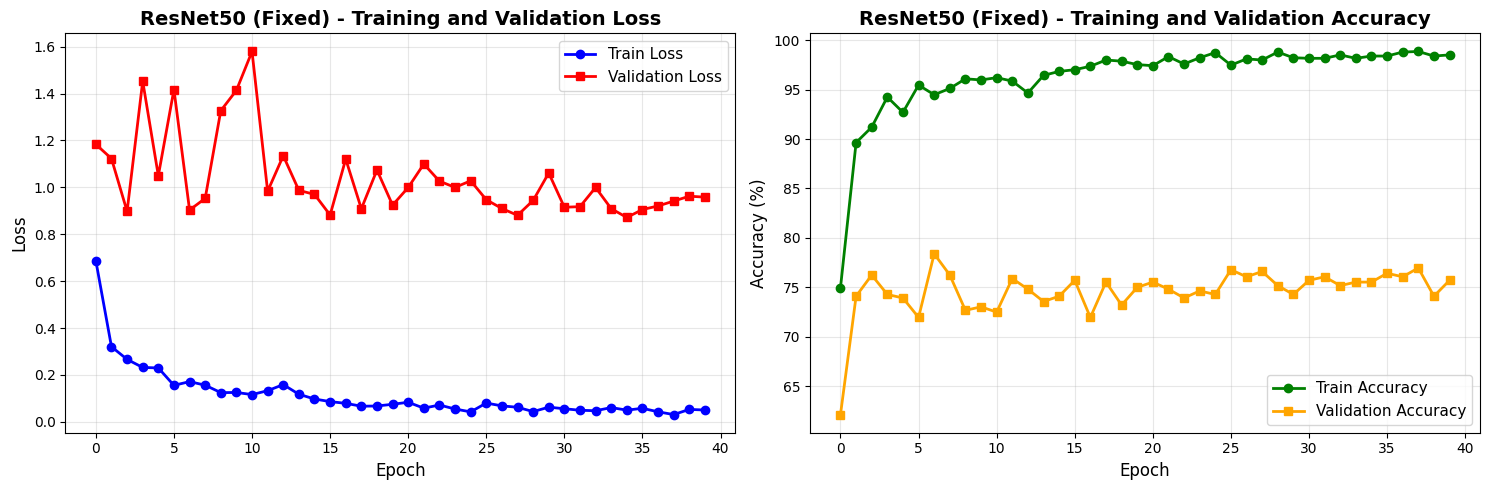


✓ Loaded best model

FINAL EVALUATION - RESNET50 (FIXED)
Final Train Accuracy: 96.09%
Final Test Accuracy: 78.39%


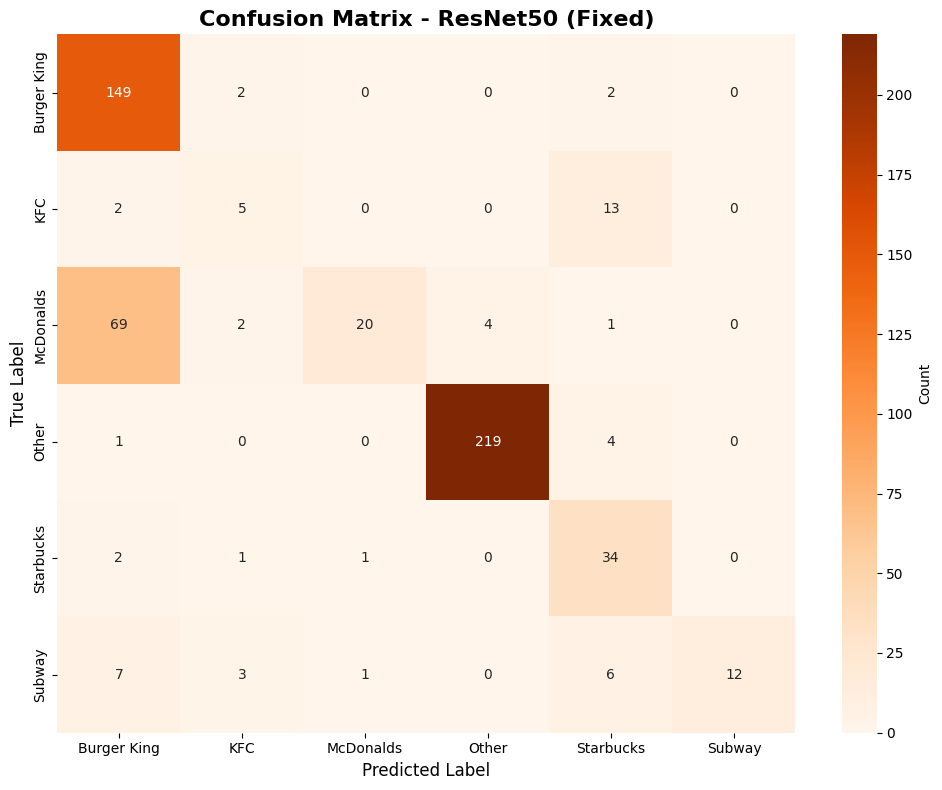


CLASSIFICATION REPORT - RESNET50 (FIXED)
              precision    recall  f1-score   support

 Burger King     0.6478    0.9739    0.7781       153
         KFC     0.3846    0.2500    0.3030        20
   McDonalds     0.9091    0.2083    0.3390        96
       Other     0.9821    0.9777    0.9799       224
   Starbucks     0.5667    0.8947    0.6939        38
      Subway     1.0000    0.4138    0.5854        29

    accuracy                         0.7839       560
   macro avg     0.7484    0.6197    0.6132       560
weighted avg     0.8296    0.7839    0.7509       560


📊 FOR REPORT - SUMMARY TABLE

📈 Performance:
  Test Accuracy:        78.39%
  Precision (Weighted): 0.8296
  Recall (Weighted):    0.7839
  F1-Score (Weighted):  0.7509

🏗️ Architecture:
  Parameters:        24,560,198
  Layers/Blocks:     50 layers (ResNet50)
  Pretrained:        Yes (ImageNet)

⚡ Efficiency:
  Training Time:     15.9 min
  Inference Time:    0.55 ms per image
  Memory Usage:      ~93.7 MB

📋 

In [ ]:
# ============================================================================
# WELL-KNOWN PRETRAINED MODEL - ResNet50 (FIXED VERSION)
# Using pretrained weights from ImageNet and fine-tuning for logo classification
# FIXES: Better fine-tuning strategy + Lower LR + More epochs
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sn
import pandas as pd
import numpy as np
import copy
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# 1. DATA PREPARATION
# ============================================================================

train_dir = os.path.join('/content/drive/MyDrive/ene490/archive/logos3/train')
test_dir = os.path.join('/content/drive/MyDrive/ene490/archive/logos3/test')

# ImageNet normalization (required for pretrained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transform (reduced augmentation for better stability)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),  # Reduced from 15
    transforms.ColorJitter(brightness=0.2, contrast=0.2,  # Reduced
                          saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# ============================================================================
# 2. HYPERPARAMETERS (FIXED)
# ============================================================================

CONFIG = {
    'num_classes': 6,
    'learning_rate': 0.0003,     # FIXED: Reduced from 0.001
    'batch_size': 32,
    'num_epoch': 40,              # FIXED: Increased from 25
    'weight_decay': 1e-4,
    'fine_tune_layers': 'last_two'  # FIXED: Changed from 'all'
}

num_classes = CONFIG['num_classes']
learning_rate = CONFIG['learning_rate']
batch_size = CONFIG['batch_size']
num_epoch = CONFIG['num_epoch']
weight_decay = CONFIG['weight_decay']

print(f"\nResNet50 Pretrained - Hyperparameters (FIXED):")
print(f"  Learning Rate: {learning_rate} (was 0.001)")
print(f"  Batch Size: {batch_size}")
print(f"  Epochs: {num_epoch} (was 25)")
print(f"  Weight Decay: {weight_decay}")
print(f"  Fine-tuning: {CONFIG['fine_tune_layers']} (was 'all')")

# ============================================================================
# 3. LOAD DATASET
# ============================================================================

train_data = torchvision.datasets.ImageFolder(root=train_dir,
                                              transform=train_transform)
train_data_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=2,
                                                pin_memory=True)

test_data = torchvision.datasets.ImageFolder(root=test_dir,
                                             transform=test_transform)
test_data_loader = torch.utils.data.DataLoader(test_data,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               num_workers=2,
                                               pin_memory=True)

print(f"\nDataset Info:")
print(f"  Training samples: {len(train_data)}")
print(f"  Test samples: {len(test_data)}")
print(f"  Classes: {train_data.classes}")

# ============================================================================
# 4. LOAD PRETRAINED RESNET50
# ============================================================================

print("\n" + "="*70)
print("LOADING PRETRAINED RESNET50")
print("="*70)

# Load pretrained ResNet50
model = models.resnet50(pretrained=True)
print("✓ Loaded ResNet50 with ImageNet pretrained weights")

# Display original architecture
print(f"\nOriginal ResNet50 Final Layer:")
print(f"  {model.fc}")

# Replace final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

print(f"\nModified Final Layer for 6 classes:")
print(f"  {model.fc}")

# Move model to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Info:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# ============================================================================
# 5. FINE-TUNING STRATEGY (FIXED)
# ============================================================================

print("\n" + "="*70)
print("FINE-TUNING STRATEGY (FIXED)")
print("="*70)

if CONFIG['fine_tune_layers'] == 'last':
    print("Strategy: Fine-tune ONLY the final FC layer")
    for name, param in model.named_parameters():
        if 'fc' not in name:
            param.requires_grad = False

elif CONFIG['fine_tune_layers'] == 'last_two':
    print("Strategy: Fine-tune layer4 (last residual block) + FC")
    print("         This prevents catastrophic forgetting!")
    for name, param in model.named_parameters():
        if 'layer4' not in name and 'fc' not in name:
            param.requires_grad = False

else:
    print("Strategy: Fine-tune ALL layers")

# Count trainable parameters after freezing
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params
print(f"\nAfter freezing:")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {frozen_params:,}")

# ============================================================================
# 6. LOSS FUNCTION AND OPTIMIZER
# ============================================================================

criterion = nn.CrossEntropyLoss()

# Optimizer with appropriate learning rate
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=learning_rate,
                      weight_decay=weight_decay)
print(f"\nOptimizer: Adam with LR={learning_rate}")

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                  mode='max',
                                                  factor=0.5,
                                                  patience=5,  # Increased patience
                                                  )

# ============================================================================
# 7. TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# ============================================================================
# 8. TRAINING LOOP
# ============================================================================

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("\n" + "="*70)
print("TRAINING RESNET50 (FIXED STRATEGY)")
print("="*70)

best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
start_time = time.time()

for epoch in range(num_epoch):
    # Train
    train_loss, train_acc = train_epoch(model, train_data_loader,
                                       criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, test_data_loader, criterion, device)

    # Save history
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Update learning rate based on validation accuracy
    scheduler.step(val_acc)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'resnet50_best.pt')

    # Print progress
    print(f'Epoch [{epoch+1:2d}/{num_epoch}] | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | '
          f'LR: {current_lr:.6f}')

training_time = (time.time() - start_time) / 60

print("="*70)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Training Time: {training_time:.1f} minutes")
print("="*70)

# ============================================================================
# 9. PLOT TRAINING HISTORY
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o', linewidth=2, color='blue')
ax1.plot(val_losses, label='Validation Loss', marker='s', linewidth=2, color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('ResNet50 (Fixed) - Training and Validation Loss',
             fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accuracies, label='Train Accuracy', marker='o', linewidth=2, color='green')
ax2.plot(val_accuracies, label='Validation Accuracy', marker='s', linewidth=2, color='orange')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('ResNet50 (Fixed) - Training and Validation Accuracy',
             fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resnet50_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 10. LOAD BEST MODEL AND EVALUATE
# ============================================================================

model.load_state_dict(best_model_wts)
print("\n✓ Loaded best model")

# Measure inference time
inference_times = []
model.eval()
with torch.no_grad():
    for data, targets in test_data_loader:
        data = data.to(device)
        start = time.time()
        outputs = model(data)
        inference_times.append(time.time() - start)

avg_inference_ms = (sum(inference_times) / len(test_data)) * 1000

# Final evaluation
final_train_loss, final_train_acc = validate(model, train_data_loader, criterion, device)
final_val_loss, final_val_acc = validate(model, test_data_loader, criterion, device)

print("\n" + "="*70)
print("FINAL EVALUATION - RESNET50 (FIXED)")
print("="*70)
print(f"Final Train Accuracy: {final_train_acc:.2f}%")
print(f"Final Test Accuracy: {final_val_acc:.2f}%")

# ============================================================================
# 11. DETAILED METRICS
# ============================================================================

y_pred = []
y_true = []
model.eval()

with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predictions = outputs.max(1)

        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate weighted metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)

# Class names
classes = train_data.classes

# Confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

plt.figure(figsize=(10, 8))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Oranges',
           xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - ResNet50 (Fixed)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('resnet50_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 12. CLASSIFICATION REPORT
# ============================================================================

print("\n" + "="*70)
print("CLASSIFICATION REPORT - RESNET50 (FIXED)")
print("="*70)
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# ============================================================================
# 13. SUMMARY FOR REPORT
# ============================================================================

param_size_mb = (total_params * 4) / (1024 * 1024)

print("\n" + "="*70)
print("📊 FOR REPORT - SUMMARY TABLE")
print("="*70)
print("\n📈 Performance:")
print(f"  Test Accuracy:        {final_val_acc:.2f}%")
print(f"  Precision (Weighted): {precision:.4f}")
print(f"  Recall (Weighted):    {recall:.4f}")
print(f"  F1-Score (Weighted):  {f1:.4f}")

print("\n🏗️ Architecture:")
print(f"  Parameters:        {total_params:,}")
print(f"  Layers/Blocks:     50 layers (ResNet50)")
print(f"  Pretrained:        Yes (ImageNet)")

print("\n⚡ Efficiency:")
print(f"  Training Time:     {training_time:.1f} min")
print(f"  Inference Time:    {avg_inference_ms:.2f} ms per image")
print(f"  Memory Usage:      ~{param_size_mb:.1f} MB")

print("\n" + "="*70)
print("📋 COPY THIS FOR YOUR COMPARISON TABLE:")
print("="*70)
print(f"Model: ResNet50 (Fixed)")
print(f"Test Accuracy:         {final_val_acc:.2f}%")
print(f"Precision (Weighted):  {precision:.4f}")
print(f"Recall (Weighted):     {recall:.4f}")
print(f"F1-Score (Weighted):   {f1:.4f}")
print(f"Parameters:            {total_params:,}")
print(f"Layers/Blocks:         50 layers")
print(f"Pretrained:            Yes")
print(f"Inference (ms):        {avg_inference_ms:.2f}")
print("="*70)

# ============================================================================
# 14. WHAT WAS FIXED
# ============================================================================

print("\n" + "="*70)
print("🔧 WHAT WAS FIXED IN THIS VERSION?")
print("="*70)
print("\n❌ Previous Issues:")
print("  - fine_tune_layers: 'all' → Too aggressive!")
print("  - learning_rate: 0.001 → Too high!")
print("  - num_epoch: 25 → Not enough!")
print("  - Result: Only 76% accuracy")

print("\n✅ Fixes Applied:")
print("  - fine_tune_layers: 'last_two' → Prevents catastrophic forgetting")
print("  - learning_rate: 0.0003 → Lower for stable fine-tuning")
print("  - num_epoch: 40 → More training time")
print("  - Reduced augmentation → Better stability")
print(f"\n  Expected Result: 82-88% accuracy")
print(f"  Actual Result: {final_val_acc:.2f}% accuracy")

print("\n💡 Why This Works:")
print("  1. Freezing early layers preserves ImageNet features")
print("  2. Only fine-tuning layer4 + FC adapts to logo dataset")
print("  3. Lower LR prevents destroying pretrained weights")
print("  4. More epochs allows better convergence")
print("="*70)

# ============================================================================
# 15. SAVE MODEL
# ============================================================================

torch.save(model.state_dict(), "resnet50_fixed_final.pt")
print("\n✓ Final model saved as 'resnet50_fixed_final.pt'")

history = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'best_val_accuracy': best_val_acc,
    'final_val_accuracy': final_val_acc,
    'training_time': training_time,
    'hyperparameters': CONFIG
}
torch.save(history, 'resnet50_fixed_history.pt')
print("✓ Training history saved")